# Remove outliers in the rest of the 3 terms

In [50]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [51]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.31f9cc53a7674e0eb1d2ef34f01e667a/status,


In [121]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba, rho
import fastjmd95
import pop_tools
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated
#import gsw

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [3]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
rho_imported = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))

## Laplacian routine

In [9]:
wet_mask = coord.wet
dxt = coord.dxt
dyt = coord.dyt
dxu = coord.dxu
dyu = coord.dyu
area_t = coord.area_t
kappa = 10 #m^2/s

In [10]:
grid = xgcm.Grid(ds.drop_dims('time'), coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [11]:
@xgcm.as_grid_ufunc(dask="parallelized")
def Laplacian(
    wet_mask: Annotated[np.ndarray, "(Y:center, X:center)"],
    dxt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    dyt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    area_t:   Annotated[np.ndarray, "(Y:center, X:center)"],
    tracer:   Annotated[np.ndarray, "(Y:center, X:center)"],
    dxu:      Annotated[np.ndarray, "(Y:right, X:right)"],
    dyu:      Annotated[np.ndarray, "(Y:right, X:right)"],
) ->          Annotated[np.ndarray, "(Y:center, X:center)"]:
    
    """Laplacian for MOM5 (tracer points).
    MOM5 uses a Northeast convention B-grid, where velocity point U(i,j) is NE of tracer point T(i,j).
    Attributes
    __________
    For information on MOM5 discretization see: https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf
    wet_mask: Mask array, 1 for ocean, 0 for land
    dxt: width in x of T-cell, model diagnostic dxt
    dyt: height in y of T-cell, model diagnostic dyt
    dxu: width in x of U-cell, model diagnostic dxu
    dyu: height in y of U-cell, model diagnostic dyu
    area_t: area of T-cell, dxt*dyt
    """    
    #x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    #y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)
    y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)

    tracer = np.nan_to_num(tracer)
    
    fx = 2 * (np.roll(tracer, -1, axis=-2) - tracer)
    fx /= dxu + np.roll(dxu, 1, axis=-1)
    fx *= x_wet_mask
    
    fy = 2 * (np.roll(tracer, -1, axis=-1) - tracer)
    fy /= dyu + np.roll(dyu, 1, axis=-2)
    fy *= y_wet_mask

    out1 = fx * 0.5 * (dyt + np.roll(dyt, -1, axis=-2))
    out1 -= (
        np.roll(fx, 1, axis=-2) * 0.5 * (dyt + np.roll(dyt, 1, axis=-2))
    )
    out1 /= area_t

    out2 = fy * 0.5 * (dxt + np.roll(dxt, -1, axis=-1))
    out2 -= (
        np.roll(fy, 1, axis=-1) * 0.5 * (dxt + np.roll(dxt, 1, axis=-1))
    )
    out2 /= area_t
    return out1 + out2

In [12]:
axis = 7*[('Y','X')]

# `SST_lap` and `SSS_lap`

In [27]:
SST_lap = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, surf_ds.surface_temp, dxu, dyu, axis=axis)
SSS_lap = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, surf_ds.surface_salt, dxu, dyu, axis=axis)

# `dens_tend`

In [29]:
drhodt = xr.apply_ufunc(jmd95numba.drhodt, surf_ds.surface_salt, surf_ds.surface_temp, 0,
                        output_dtypes=[surf_ds.surface_temp.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()
drhods = xr.apply_ufunc(jmd95numba.drhods, surf_ds.surface_salt, surf_ds.surface_temp, 0,
                        output_dtypes=[surf_ds.surface_salt.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()

In [30]:
dens_tend = (drhodt*SST_lap + drhods*SSS_lap)

# `rho_lap`

In [13]:
rho_lap_outliers = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, rho_imported.rho_test, dxu, dyu, axis=axis)

rho_lap_outliers

<xarray.DataArray (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mul, shape=(7305, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

/tmp/ipykernel_533/867043117.py:43: RuntimeWarning: invalid value encountered in divide
  out1 /= area_t
/tmp/ipykernel_533/867043117.py:49: RuntimeWarning: invalid value encountered in divide
  out2 /= area_t
/tmp/ipykernel_533/867043117.py:43: RuntimeWarning: invalid value encountered in divide
  out1 /= area_t
/tmp/ipykernel_533/867043117.py:49: RuntimeWarning: invalid value encountered in divide
  out2 /= area_t
/tmp/ipykernel_533/867043117.py:43: RuntimeWarning: invalid value encountered in divide
  out1 /= area_t
/tmp/ipykernel_533/867043117.py:49: RuntimeWarning: invalid value encountered in divide
  out2 /= area_t


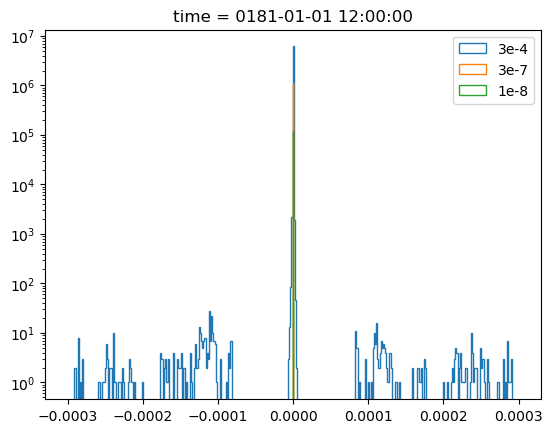

In [14]:
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-4, 3e-4, 400), yscale="log", 
                                       histtype="step", label='3e-4')
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-7, 3e-7, 400), yscale="log", 
                                       histtype="step", label='3e-7')
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-8, 3e-8, 400), yscale="log", 
                                       histtype="step", label='1e-8')
plt.legend();

/tmp/ipykernel_533/867043117.py:43: RuntimeWarning: invalid value encountered in divide
  out1 /= area_t
/tmp/ipykernel_533/867043117.py:49: RuntimeWarning: invalid value encountered in divide
  out2 /= area_t
/tmp/ipykernel_533/867043117.py:43: RuntimeWarning: invalid value encountered in divide
  out1 /= area_t
/tmp/ipykernel_533/867043117.py:49: RuntimeWarning: invalid value encountered in divide
  out2 /= area_t


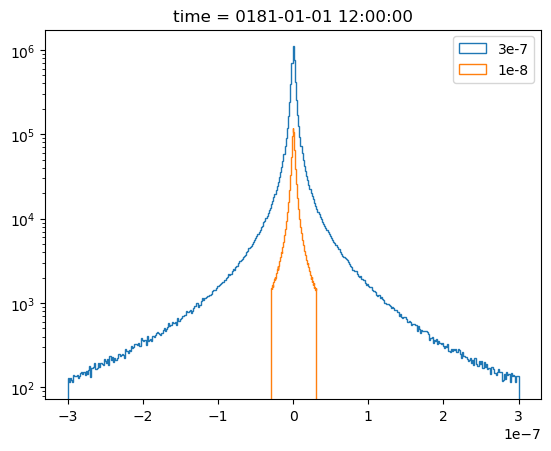

In [15]:
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-7, 3e-7, 400), yscale="log", 
                                       histtype="step", label='3e-7')
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-8, 3e-8, 400), yscale="log", 
                                       histtype="step", label='1e-8')
plt.legend();

# Remove outliers for ALL terms

In [16]:
mask = (abs(rho_lap_outliers) < 3e-7)

In [31]:
rho_lap_no_outliers = rho_lap_outliers.where(mask)
SST_lap_no_outliers = SST_lap.where(mask)
SSS_lap_no_outliers = SSS_lap.where(mask)

In [32]:
dens_tend = drhodt*SST_lap_no_outliers + drhods*SSS_lap_no_outliers

In [33]:
cabbeling = dens_tend - rho_lap_no_outliers

/tmp/ipykernel_533/867043117.py:43: RuntimeWarning: invalid value encountered in divide
  out1 /= area_t
/tmp/ipykernel_533/867043117.py:49: RuntimeWarning: invalid value encountered in divide
  out2 /= area_t


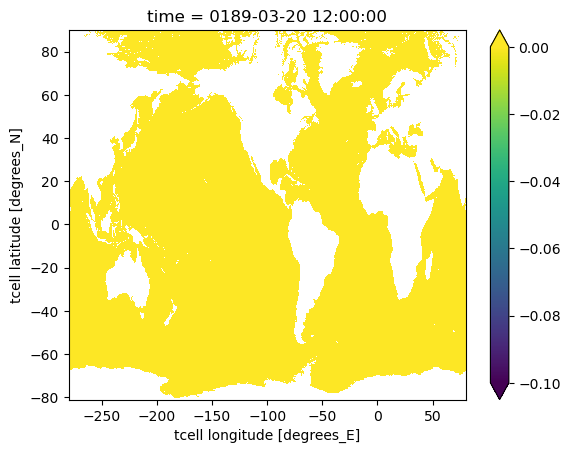

In [36]:
(rho_lap_no_outliers + cabbeling - dens_tend).isel(time=3000).where(wet_mask).plot(robust=True, vmin=1e-20)

# Check resdiual of histogram

In [37]:
#rmask = mask
#mask_bins = np.arange(rmask.min()-0.5, rmask.max()+0.5)
mask_bins = np.array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 12.5, 99.5])
rho = rho_imported.rho_test # tendencies.rho
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)

In [38]:
avg_mld = ds.mld.mean('time').compute()
weights = coord.area_t*avg_mld

In [39]:
from xhistogram.xarray import histogram
def global_hist_func(ds, variable):
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                    weights=(ds[variable].fillna(0.)*(avg_mld*coord.area_t).fillna(0.)),
                    dim=['xt_ocean', 'yt_ocean']) / delta_rho
    return hist

In [40]:
tendencies = xr.merge([(drhodt*SST_lap_no_outliers).rename('sst'),
                       (drhods*SSS_lap_no_outliers).rename('sss'),
                      rho_lap_no_outliers.rename('rho_lap'),
                      cabbeling.rename('cabbeling')])

In [41]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [42]:
all_tendencies = list(tendencies.data_vars)

In [44]:
global_hists = xr.merge([global_hist_func(tendencies, var).rename('OMEGA_' + var) for var in all_tendencies])

In [45]:
global_hists

<xarray.Dataset>
Dimensions:          (time: 7305, rho0_bin: 199)
Coordinates:
  * time             (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
Data variables:
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

/tmp/ipykernel_533/867043117.py:43: RuntimeWarning: invalid value encountered in divide
  out1 /= area_t
/tmp/ipykernel_533/867043117.py:49: RuntimeWarning: invalid value encountered in divide
  out2 /= area_t


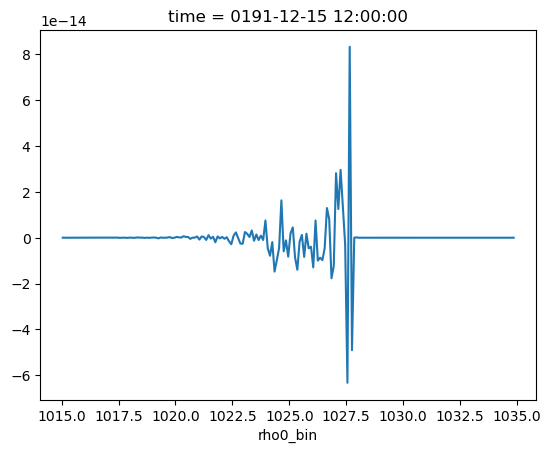

In [47]:
#check residual
((global_hists.OMEGA_rho_lap + global_hists.OMEGA_cabbeling - 
  global_hists.OMEGA_sss - global_hists.OMEGA_sst)/1e6).isel(time=4000).plot();

/tmp/ipykernel_533/867043117.py:43: RuntimeWarning: invalid value encountered in divide
  out1 /= area_t
/tmp/ipykernel_533/867043117.py:49: RuntimeWarning: invalid value encountered in divide
  out2 /= area_t


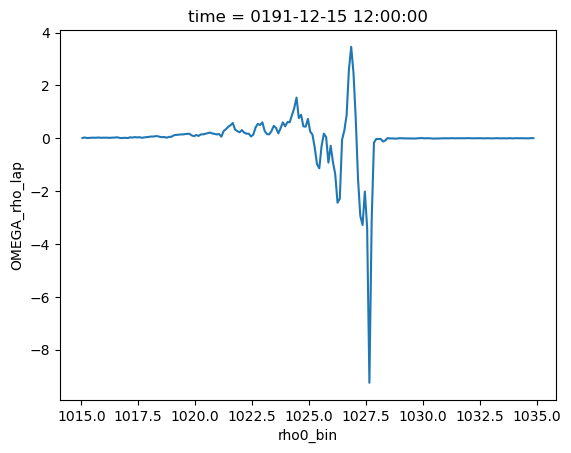

In [49]:
(global_hists.OMEGA_rho_lap.isel(time=4000)/1e6).plot()

# Upload new tendency terms w outliers removed

In [52]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [53]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [54]:
from tqdm import tqdm
import zarr

def to_zarr_split(ds, mapper, split_dim="time", split_interval=1):
    print(f"Writing to {mapper.root} ...")

    n = len(ds[split_dim])
    splits = list(range(0, n, split_interval))

    # Make sure the last item in the list covers the full length
    # of the time on our dataset
    if splits[-1] != n:
        splits = splits + [n]

    split_datasets = []
    for ii in range(len(splits) - 1):
        start = splits[ii]
        stop = splits[ii + 1]
        split_datasets.append(ds.isel({split_dim: slice(start, stop)}))

    # write the first array
    # TODO: move the first write to the loop so it is counted in the viz bar
    split_datasets[0].to_zarr(mapper)
    for ds_split in tqdm(split_datasets[1:None]):
        ds_split.to_zarr(mapper, append_dim=split_dim)

    # overwrite the split dimension as single chunk (this should reproduce
    # what xr.to_zarr would do
    g = zarr.open_group(mapper)
    del g[split_dim]
    
    ds[[split_dim]].load().to_zarr(mapper, mode='a')
    zarr.consolidate_metadata(mapper)

In [55]:
mapper = gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tendencies_outliers_rm.zarr')
to_zarr_split(tendencies, mapper)

Writing to pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tendencies_outliers_rm.zarr ...


100%|██████████| 7304/7304 [25:09:48<00:00, 12.40s/it]   
